# SageMaker Processing Job & LakeFormation Integration - Vend Temporary Credentials to read data from S3 in a `Pandas` and `Spark` dataframe
---

This example shows how to use LakeFormation's `credential vending capability` from within a SageMaker Processing Job and based on that, query `LakeFormation` to see which `columns` does a `Role` being used have access to from the table being queried from Amazon S3.

### Before running this notebook, read the following roles required, steps and permissions to be assigned given in the [README.md](/README.md) file.

In [ ]:
# This cell only needs to be run once
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [ ]:
# import libraries
import os
import sys
import json
import boto3
import logging
import pandas as pd
from io import StringIO
from typing import List, Dict
from sagemaker import get_execution_role
from botocore.exceptions import ClientError
# import scripts as modules to grant fine-grained permissions
# and read data from S3 in pandas and spark
from lf_vend_credentials import get_lf_temp_credentials
from read_data import read_pandas_lf_data, read_spark_lf_data

In [ ]:
# set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

#### If you have a table/database that already exists, replace the variable names below with your resource names, and skip the steps to create the Database and Table

In [ ]:
REGION = boto3.session.Session().region_name

# initialize the sessions that will be used for creation of tables, databases, and calling the APIs
lf_session = boto3.session.Session(region_name=REGION)
lf_client = lf_session.client('lakeformation')
glue_client = lf_session.client('glue')
sts_client = lf_session.client('sts')

# Initialize the account ID, caller ARN, table database name of your choice, and the bucket name (that you will create associated to the table and DB path)
ACCOUNT_ID: str = sts_client.get_caller_identity()['Account'] 
CALLER_ARN: str = sts_client.get_caller_identity()['Arn']
# Replace with your database and table name if this already exists
DATABASE_NAME: str = f'cred_vending_test_db_{ACCOUNT_ID}'
TABLE_NAME: str = f'cred_vending_test_table_{ACCOUNT_ID}'
# replace with your bucket name here
BUCKET_NAME: str = 'cred-vending-test-bucket'
DUMMY_CSV_FILE: str = f'dummy_data_{ACCOUNT_ID}.csv'

# Initialize the db and table location in s3  - register the s3 location with a relevant role and grant access for the sagemaker execution and admin role to the database and table
DATABASE_S3_LOCATION: str = f's3://{BUCKET_NAME}/{DATABASE_NAME}'
TABLE_S3_LOCATION: str = f'{DATABASE_S3_LOCATION}/{TABLE_NAME}'

# Catalog id is the account id, set the name of the IAM role to be given fine-grained access to below
ASSUMED_ROLE_NAME: str = 'lf_role_assumed'
SAGEMAKER_EXECUTION_ROLE_NAME: str = get_execution_role()
CATALOG_ID: str = ACCOUNT_ID # abstract the role name and account ID
LF_ROLE_TO_ASSUME: str = f'arn:aws:iam::{ACCOUNT_ID}:role/{ASSUMED_ROLE_NAME}'
# Set appropriate IAM and lakeformation permissions for this role in your aws account. Follow the README.md for detailed instructions
SAGEMAKER_ROLE_ARN: str = f'arn:aws:iam::{ACCOUNT_ID}:role/service-role/{SAGEMAKER_EXECUTION_ROLE_NAME}'
logger.info(f"DB path location: {DATABASE_S3_LOCATION}, Table path location: {TABLE_S3_LOCATION}")

# Add your lakeformation session tag value below that you set on the console. For more instructions, 
# view: https://docs.aws.amazon.com/lake-formation/latest/dg/full-table-credential-vending.html
lf_tag_value: str = 'sessionfortag'
logger.info(f"SageMaker execution role being used for this notebook: {SAGEMAKER_EXECUTION_ROLE_NAME}")

### Create a Database and Glue Table (Skip this following step if you already have a database and a Glue table in your account):

Add the `sagemaker-execution-role` as an the administrator in the lakeformation console. Make sure to give this role full access to your specific `database` **AND** `table`.

***Skip this step if you have a database and table already created. Make sure to use the table location for your Glue Data Catalogue to read from s3 later***

In [ ]:
# create a database using the database name and database location
try:
    glue_client.create_database(
        DatabaseInput = {
            'Name': DATABASE_NAME,
            'LocationUri' : DATABASE_S3_LOCATION
        }
    )
except Exception as e:
    logger.error(f"the database could not be created: {e}")

# create a table using the table name, location, and table description
try:
    glue_client.create_table(
        DatabaseName=DATABASE_NAME,
        TableInput={
            'Name': TABLE_NAME,
            'StorageDescriptor': {
                'Columns': [
                    {'Name': 'customer_id','Type': 'bigint'},
                    {'Name': 'prefix','Type': 'string'},
                    {'Name': 'first_name','Type': 'string'},
                    {'Name': 'middle_name','Type': 'string'},
                    {'Name': 'last_name','Type': 'string'},
                    {'Name': 'suffix','Type': 'string'},
                    {'Name': 'gender','Type': 'string'},
                    {'Name': 'dob','Type': 'string'},
                    {'Name': 'phone','Type': 'string'},
                    {'Name': 'building_number','Type': 'bigint'},
                    {'Name': 'street_name','Type': 'string'},
                    {'Name': 'city','Type': 'string'},
                    {'Name': 'cust_zip','Type': 'bigint'},
                    {'Name': 'country','Type': 'string' }
                ],
                'Location': TABLE_S3_LOCATION,
                'InputFormat': 'org.apache.hadoop.mapred.TextInputFormat',
                'OutputFormat': 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat',
                'Compressed': False,
                'NumberOfBuckets': 0,
                'SerdeInfo': {
                    'SerializationLibrary': 'org.apache.hadoop.hive.serde2.OpenCSVSerde',
                    'Parameters': {
                        'separatorChar': ','
                    }
                },
                'SortColumns': [],
                'StoredAsSubDirectories': False
            },
            'PartitionKeys': [],
            'TableType': 'EXTERNAL_TABLE',
            'Parameters': {
                'classification': 'csv',
                'lakeformation.aso.status': 'false'
            }
        }
    )
except Exception as e:
    logger.error(f"the table could not be created: {e}")


### Inserting sample data in the Glue Table S3 Path
---

If you already have data in s3, then run the crawler and skip the step below. Replace the `DUMMY_CSV_FILE`, `DATABASE_S3_LOCATION`, and `TABLE_S3_LOCATION` with pre-configured resources if they already exist in your account. If not, follow the steps below to insert dummy data in the `S3_path` that corresponds to your Glue Data Catalog.

***For this next cell, if you want to insert data in your S3 bucket, give put object access to the SageMaker Execution role for that `S3_path`, else insert it manually. You can choose not to run the step below***

In [ ]:
# Insert dummy data and send the table to the given s3 path for the table (this is an optional step, you will have to run the crawler
# on your existing files in s3 to create a table). We are inserting this data to see the effect of granting fine grained access
# to a role and getting only the metadata that that role has fine grained access to.

# Sample data for insertion
data = pd.DataFrame({
    'customer_id': [1, 2],
    'prefix': ['Mr.', 'Ms.'],
    'first_name': ['Madhur', 'Jane'],
    'middle_name': ['A', 'B'],
    'last_name': ['Prashant', 'Doe'],
    'suffix': ['Jr', 'Sr'],
    'gender': ['Male', 'Female'],
    'dob': ['2020-01-01', '1992-02-02'],
    'phone': ['1234', '5678'],
    'building_number': [123, 456],
    'street_name': ['cunard St', 'cunard St'],
    'city': ['city1', 'city2'],
    'cust_zip': [1111, 2222],
    'country': ['US', 'INDIA']
})

# Convert data to CSV
csv_buffer = StringIO()
data.to_csv(csv_buffer, index=False)
s3_resource = boto3.resource('s3')

try:
    object_key = f"{DATABASE_NAME}/{TABLE_NAME}/{DUMMY_CSV_FILE}" 
    logger.info(f"object key for the csv file: {object_key}")
    # add put object for this s3 bucket in the sagemaker execution role to run this cell
    s3_resource.Object(BUCKET_NAME, object_key).put(Body=csv_buffer.getvalue())
    logger.info(f"sample data successfully uploaded to {TABLE_S3_LOCATION}")
except Exception as e:
    logger.error(f"Failed to upload data to {TABLE_S3_LOCATION}: {e}")

In [ ]:
# view the metadata of the entire data that is sent to Amazon S3
data.head()

#### Enable `AllowFullTableExternalDataAccess` in the `DataLakeSettings` using the `get_data_lake_settings` API to be able to get temporary credentials to get access to the glue table

In [ ]:
settings = lf_client.get_data_lake_settings()

# Set the `AllowFullTableExternalDataAccess` in the settings for datalake to True for this role, in order to vend temporary glue table credentials
if 'AllowFullTableExternalDataAccess' not in settings['DataLakeSettings'] or settings['DataLakeSettings']['AllowFullTableExternalDataAccess'] == False:
    settings_raw = settings['DataLakeSettings']
    settings_raw['AllowFullTableExternalDataAccess'] = True
    lf_client.put_data_lake_settings(DataLakeSettings=settings_raw)

logger.info(f"Data lake settings: {json.dumps(settings, indent=2)}")

These are the credentials that are used by the role to get access to a database/table or fine grained access to certain columns.

In [ ]:
# This is the format that is followed for the table arn. For more information, view: 
# https://repost.aws/questions/QU6S243zI_SQKYlezRl_Efqg/how-to-get-arn-for-lake-formation-table
TableArn=f'arn:aws:glue:{REGION}:{ACCOUNT_ID}:table/{DATABASE_NAME}/{TABLE_NAME}'
TableArn

In [ ]:
# This works because the user has full table access, and the AllowFullTableExternalDataAccess is enabled
resp = lf_client.get_temporary_glue_table_credentials(
    TableArn=TableArn,
    Permissions=[ 'ALL' ],
    SupportedPermissionTypes=['COLUMN_PERMISSION'],
)
print(f"Access Key: {resp['AccessKeyId']} Expiration: {resp['Expiration']}")

### Lakeformation Fine-Grained Access:
---
In this section, we call three functions: `get_lf_temp_credentials` to grant fine-grained access on the `LF_ROLE_TO_ASSUME` role and vend temporary glue table credentials, `read_pandas_lf_data` to read data from S3 in a pandas dataframe, and `read_spark_lf_data` to read data from S3 in a spark dataframe.

In [ ]:
# This function call returns a dictionary that contains temporary glue table credentials, s3_path to the glue data catalog, file type, 
# to read metadata from and authorized columns
table_info_and_credentials = get_lf_temp_credentials(role=LF_ROLE_TO_ASSUME,
                                                        db_name=DATABASE_NAME,
                                                        table_name=TABLE_NAME,
                                                        columns=['street_name', 'city', 'cust_zip'],  
                                                        lf_tag_value=lf_tag_value)

### Read Data from S3 using the Temporary credentials and s3_path
---

Read data in a `pandas dataframe`

In [ ]:
# reading data using the temporary vended credentials into a pandas dataframe 
extracted_pandas_df = read_pandas_lf_data(table_info_and_credentials
                                          =table_info_and_credentials)
# View metadata on columns that the role has fine grained access on
extracted_pandas_df

Read data in a `spark dataframe`

In [ ]:
# reading data using the temporary vended credentials into a pandas dataframe 
extracted_spark_df = read_spark_lf_data(table_info_and_credentials
                                          =table_info_and_credentials, 
                                           use_s3a = True) # add the s3 bool
extracted_spark_df

***Now, you can see that the second assumed role has been granted fine grained access to columns

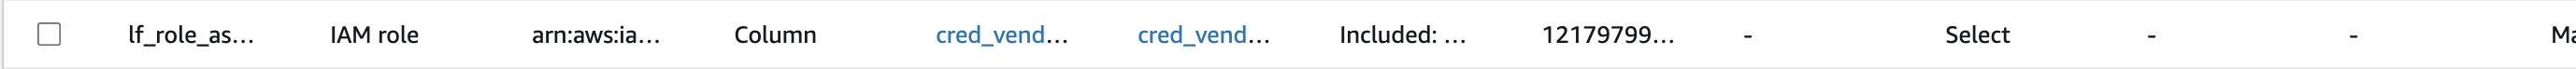